# Monk2
Grid Search for Monk2 dataset model selection


In [202]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.components.Validation.KFoldCrossValidation import validate
from exclusiveAI.components.CallBacks import EarlyStoppingCallback
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk2
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk2 dataset 

In [203]:
training_data, training_labels, test_data, test_labels = read_monk2("../exclusiveAI/datasets/")

One-Hot Encoding Training Dataset

In [204]:
training_data = one_hot_encoding(training_data)

One-Hot Encoding Test Dataset

In [205]:
test_data = one_hot_encoding(test_data)

Getting the (most interesting) models from the big grid search 

In [206]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()][1]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 64
epochs = 500

final_file = "monk2_models_configs_hist3.json"

if not os.path.exists(final_file):
    dir_path = "Monk2/"
    
    all_json_data = read_json_files(dir_path)
    regularizations = all_json_data['regularization'].unique().tolist()
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    momentums = all_json_data['momentum'].unique().tolist()
    num_of_layers = [1]
    num_of_units = set([unit1 if unit1!=1 else 2 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = all_json_data['initializers'].value_counts().index.tolist()
    activations = ['sigmoid', 'tanh']
    
    # ea = EarlyStoppingCallback(patiente_limit=50, eps=)
    # 
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True,
                                     callbacks=["earlystopping"], output_activation='sigmoid', show_line=False,
                                     ).get_configs()
    len(myConfigurator)
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs,
                              batch_size=batch_size, num_models=100, workers=-2, number_of_initializations=2, return_models_history=True,
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json(final_file)
else: 
    with open(final_file, 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [207]:
my_configs = []
for config in configs[1]:
    config['callbacks'] = ['earlystopping_1e-4_20_False']
# ea = EarlyStoppingCallback(restore_weights=True)
if __name__ == '__main__':
    # for config in configs[1]:
    #     config['callbacks'] = [ea]
    my_configs.append(
        validate(configs[1], x=training_data, y_true=training_labels, epochs=epochs, return_models_history=True,
                          batch_size=batch_size, max_configs=100, number_of_initializations=1, n_splits=4, parallel=False
                          ))
    
    # my_configs.append(
    #     hold_out(configs[1], training=training_data, training_target=training_labels, epochs=epochs, return_models_history=True,
    #                       batch_size=batch_size, num_models=100, number_of_initializations=2,
    #                       ))

configs=my_configs[0]

Models: 100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


In [208]:
models = []
old_histories = configs[0]
configs=configs[1]
with tqdm(total=len(configs)) as pbar:
    for old_hist, config in zip(old_histories, configs):
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mse'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, old_hist['binary_accuracy'][-1],  old_hist['val_binary_accuracy'][-1], old_hist['mse'],  old_hist['val_mse'], model.history['mse'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'Old_Accuracy', 'Old_Accuracy_val', 'Old_History', 'Old_History_val', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


In [216]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'History_Std', 'Score', 'Test_Score'])
df_sorted = df_sorted[df_sorted['Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['Old_Accuracy_val'] >= 1]
# df_sorted = df_sorted[df_sorted['History_Std'] <= 0.09]
# df_sorted = df_sorted[df_sorted['Test_Score'] <= 0.0003]
df_sorted = df_sorted[df_sorted['Score'] <= 0.0003]
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
old_histories = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History']].values}
old_histories_val = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History_val']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,Old_Accuracy,Old_Accuracy_val,Old_History,Old_History_val,History,Model,Config,Num_Layers,Num_of_Units,Name
16,0.000265,0.067007,1.0,0.000313,1.0,118,1.0,1.0,"[0.24496791, 0.24353327, 0.24123462, 0.2393728...","[0.25582802, 0.25525954, 0.25494745, 0.2533497...","[0.2424003, 0.23403028, 0.22918807, 0.2247379,...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-06, 'learning_rate': 0.7...",1,[3],Model3675
20,0.000256,0.068918,1.0,0.000295,1.0,130,1.0,1.0,"[0.24339007, 0.23212658, 0.22986229, 0.2333737...","[0.23422907, 0.2124321, 0.19599392, 0.19251353...","[0.25797203, 0.23088568, 0.24146688, 0.2349796...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.7...",1,[4],Model227
66,0.000292,0.073261,1.0,0.000330,1.0,120,1.0,1.0,"[0.24995537, 0.24150974, 0.2358852, 0.23276235...","[0.26774785, 0.2610276, 0.2555969, 0.2517838, ...","[0.28351092, 0.2464867, 0.24096961, 0.23112027...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.7...",1,[4],Model221
59,0.000293,0.073948,1.0,0.000336,1.0,96,1.0,1.0,"[0.24235946, 0.22572859, 0.2196771, 0.21963416...","[0.24366343, 0.23622096, 0.24111085, 0.2452898...","[0.28014857, 0.24121189, 0.2346079, 0.22936814...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.8...",1,[4],Model5
7,0.000283,0.076654,1.0,0.000325,1.0,123,1.0,1.0,"[0.25153813, 0.24481277, 0.2394875, 0.2389296,...","[0.2517471, 0.24493508, 0.23945905, 0.23877248...","[0.24945073, 0.23830506, 0.23480348, 0.2350073...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.8, ...",1,[3],Model1743
24,0.000299,0.081813,1.0,0.000488,1.0,137,1.0,1.0,"[0.2528499, 0.24475324, 0.23826364, 0.23759605...","[0.25264215, 0.24835409, 0.2473813, 0.25045925...","[0.2583098, 0.24087001, 0.2350263, 0.23802723,...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-06, 'learning_rate': 0.7...",1,[4],Model3689
1,0.000298,0.083268,1.0,0.000715,1.0,131,1.0,1.0,"[0.25551474, 0.24169028, 0.23039812, 0.2310277...","[0.25763223, 0.23822062, 0.21804947, 0.2112421...","[0.24811997, 0.23873076, 0.23590006, 0.2392132...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.7, ...",1,[3],Model1965
35,0.000283,0.083535,1.0,0.001094,1.0,119,1.0,1.0,"[0.2537234, 0.24908291, 0.24412566, 0.24351567...","[0.25908688, 0.2483066, 0.23207343, 0.22081792...","[0.25090256, 0.23810956, 0.23496932, 0.2356051...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.8, ...",1,[4],Model1745
21,0.000275,0.083933,1.0,0.000605,1.0,127,1.0,1.0,"[0.2466631, 0.24219759, 0.23770577, 0.23797938...","[0.251284, 0.25361496, 0.26241553, 0.27252758,...","[0.24741147, 0.23619391, 0.23578577, 0.2378752...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-06, 'learning_rate': 0.8...",1,[3],Model3477
19,0.000289,0.084672,1.0,0.000334,1.0,126,1.0,1.0,"[0.248426, 0.24394402, 0.23893985, 0.23830295,...","[0.24866745, 0.24290726, 0.23529448, 0.2328434...","[0.25798482, 0.24038407, 0.2353573, 0.23748016...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.7, ...",1,[4],Model1961


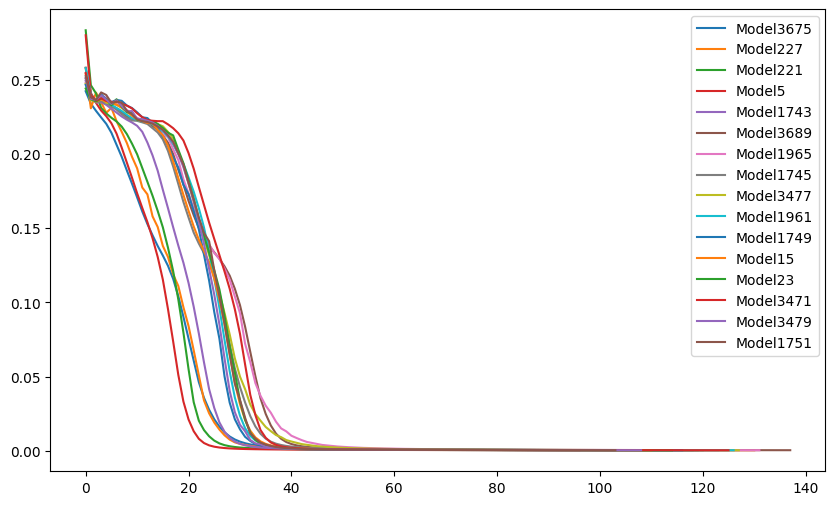

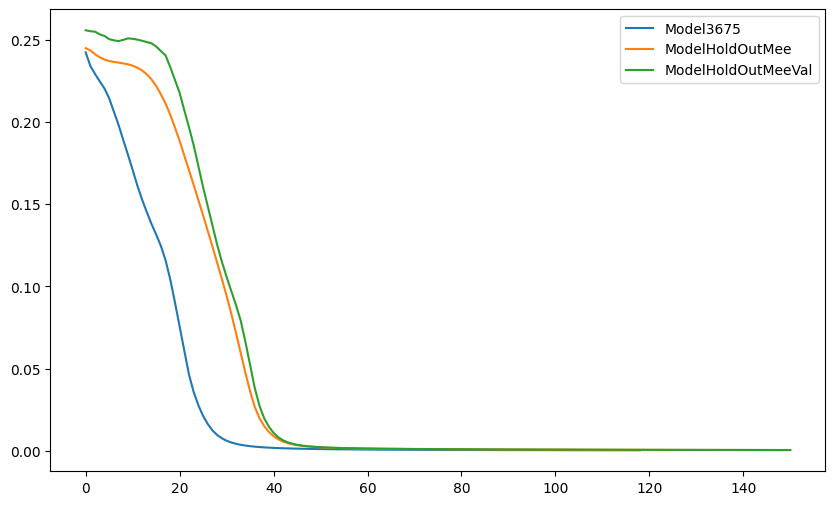

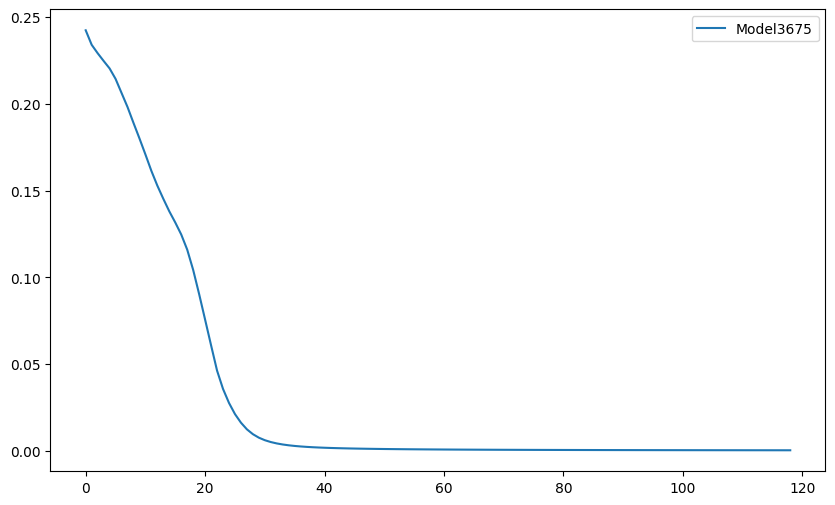

In [217]:
plot_history(histories)
# plot_history({'Model3699': histories['Model3699'], 'Model3699_old': old_histories['Model3699'], 'Model3699_Val': old_histories_val['Model3699']})
plot_history({list(histories)[0]: list(histories.values())[0], 'ModelHoldOutMee': list(old_histories.values())[0], 'ModelHoldOutMeeVal': list(old_histories_val.values())[0]})
plot_history({list(histories)[0]: list(histories.values())[0]})


Selected row:
Score                                                        0.000292
History_Std                                                  0.073261
Accuracy                                                          1.0
Test_Score                                                    0.00033
Test_Accuracy                                                     1.0
Trained_Epochs                                                    120
Old_Accuracy                                                      1.0
Old_Accuracy_val                                                  1.0
Old_History         [0.24995537, 0.24150974, 0.2358852, 0.23276235...
Old_History_val     [0.26774785, 0.2610276, 0.2555969, 0.2517838, ...
History             [0.28351092, 0.2464867, 0.24096961, 0.23112027...
Model               <exclusiveAI.components.NeuralNetwork.NeuralNe...
Config              {'regularization': 1e-07, 'learning_rate': 0.7...
Num_Layers                                                          1
Num_of

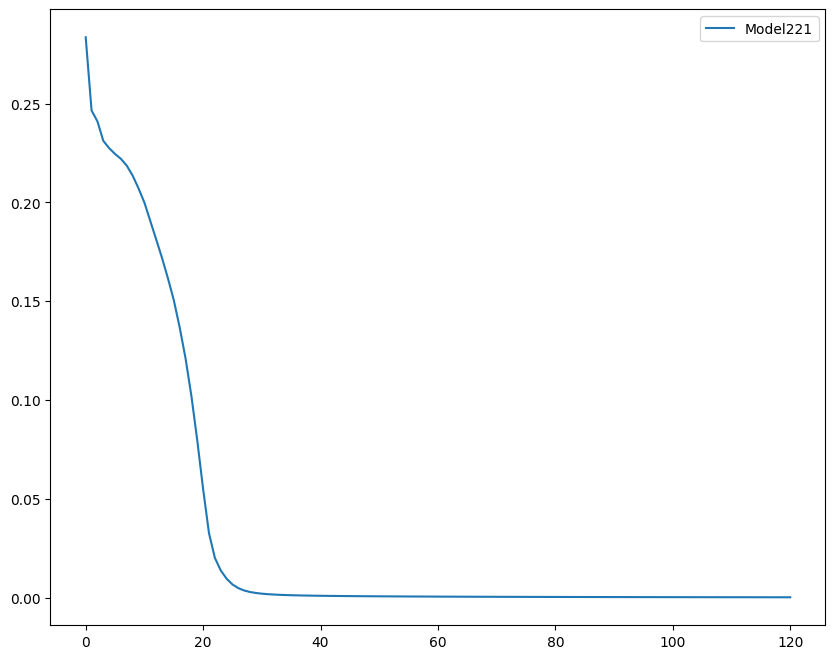

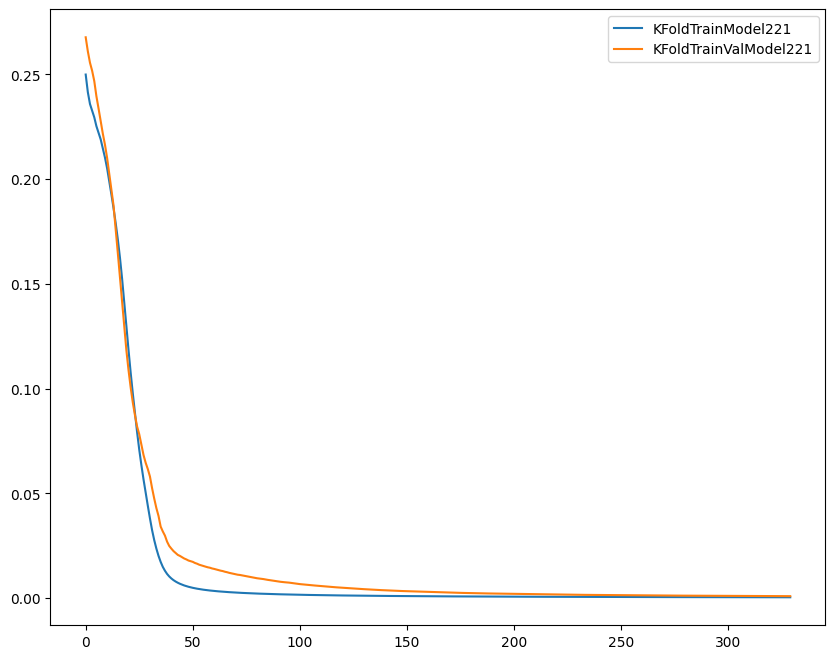

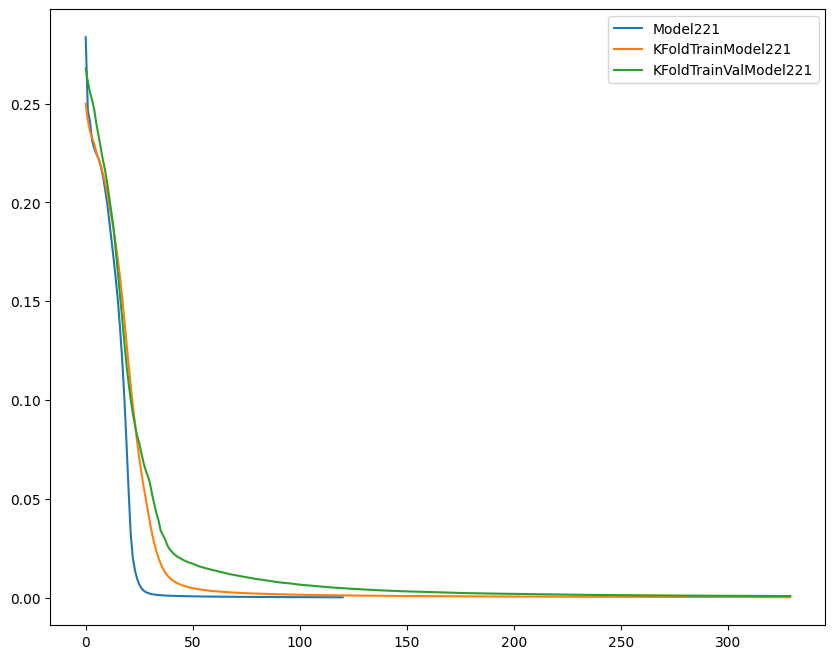

In [223]:
def find_least_difference_row(my_df):
    min_diff = float('inf')
    selected_row = None

    for index, row in my_df.iterrows():
        array1 = np.array(row['History'])
        # differences1 =  (np.diff(array1) - np.mean(array1)) /np.mean(array1)
        differences1 =  (np.diff(array1) / np.mean(array1))
        min_consecutive_difference = np.min(differences1)

        if min_consecutive_difference < min_diff:
            min_diff = min_consecutive_difference
            selected_row = row

    return selected_row

# Example usage:
result_row = find_least_difference_row(df_sorted)
print("Selected row:")
print(result_row)
plot_history({result_row["Name"]: result_row['History']}, fig_size=(10,8))
plot_history({'KFoldTrain'+result_row["Name"]: result_row['Old_History'], 'KFoldTrainVal'+result_row["Name"]: result_row['Old_History_val']}, fig_size=(10,8))
plot_history({result_row["Name"]: result_row['History'], 'KFoldTrain'+result_row["Name"]: result_row['Old_History'], 'KFoldTrainVal'+result_row["Name"]: result_row['Old_History_val']}, fig_size=(10,8))
result_row.to_csv('Monk2_train.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


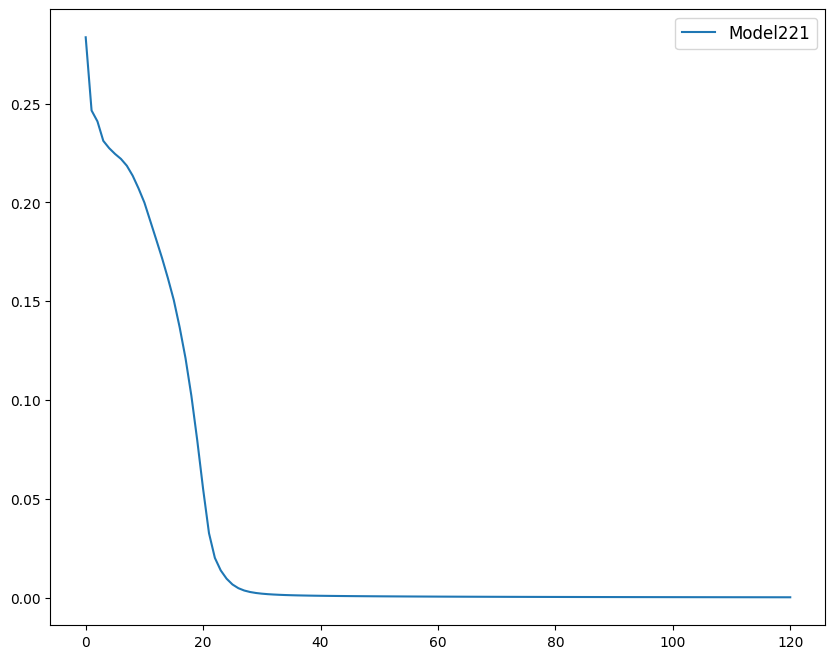

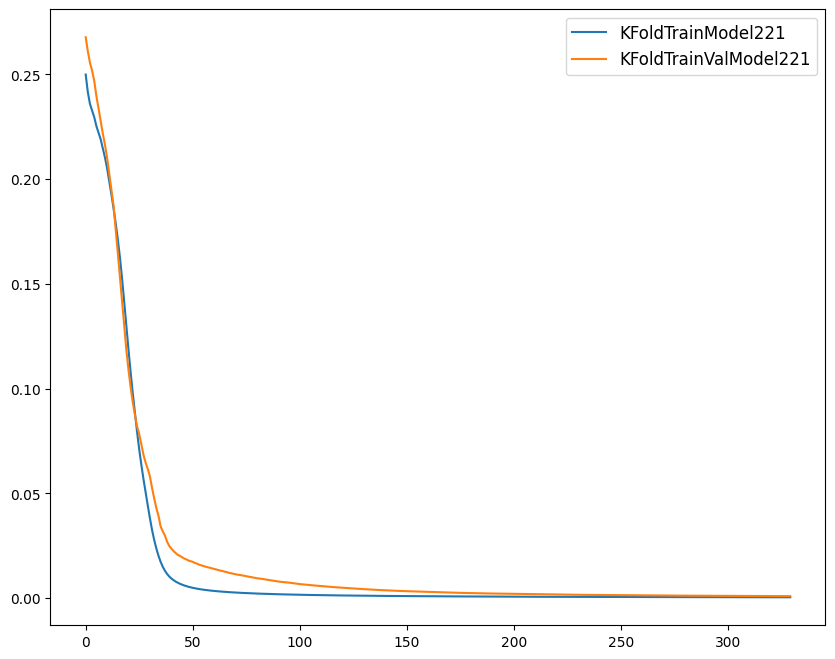

In [222]:
import matplotlib.pyplot as plt
def plot_history2(name, lines: dict, fig_size=(10, 6)):
    plt.figure(figsize=fig_size)
    for elem in lines:
        plt.plot(lines[elem], label=elem)
    plt.legend(fontsize=12)
    plt.savefig(name+'.eps', format='eps')
    plt.savefig(name+'.png', format='png')

plot_history2(name='Monk2_train', lines={result_row["Name"]: -np.sort(-np.array(result_row['History']))}, fig_size=(10,8))
plot_history2(name='Monk2_KFold', lines={'KFoldTrain'+result_row["Name"]: -np.sort(-np.array(result_row['Old_History'])), 'KFoldTrainVal'+result_row["Name"]: -np.sort(-np.array(result_row['Old_History_val']))}, fig_size=(10,8))
